In [1]:
# Import necessary libraries
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
import torch
import numpy as np
import pandas as pd
import evaluate
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Define model and tokenizer
model_name = "xlm-roberta-base"
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)
# model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)
model = XLMRobertaForSequenceClassification.from_pretrained("./fine_tuned_model/final_model")

In [12]:
# Load the training data (e.g., English hate speech data)
dataset = load_dataset("hate_speech18", "english")

In [13]:
# Tokenize the training and validation data
def tokenize_data(example):
    return tokenizer(example["text"], truncation=True, padding='max_length', max_length=128)

In [6]:
# Split the English data into training and validation sets
train_test_split = dataset['train'].train_test_split(test_size=0.2)
train_data = train_test_split['train'].map(tokenize_data, batched=True)
val_data = train_test_split['test'].map(tokenize_data, batched=True)

Map:   0%|          | 0/8755 [00:00<?, ? examples/s]

Map:   0%|          | 0/2189 [00:00<?, ? examples/s]

In [7]:
# Prepare datasets for PyTorch
train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [8]:
# Define fine-tuning specific training arguments
training_args = TrainingArguments(
    output_dir="fine_tuned_model",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,  # Fine-tuning typically doesn’t need as many epochs
    save_strategy="epoch",
    learning_rate=2e-5,  # Small learning rate for fine-tuning
    logging_dir="./logs",
)

# Re-initialize the Trainer for fine-tuning
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,  # Use English or Marathi here
    eval_dataset=val_data,
)

/opt/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [9]:
# Extract and plot the training and validation losses
def plot_training_curves(log_history):
    train_losses = [log["loss"] for log in log_history if "loss" in log]
    val_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
    epochs = range(1, len(val_losses) + 1)

    plt.figure(figsize=(6, 6))
    plt.plot(epochs, train_losses[:len(epochs)], 'o-', label="Training Loss")
    plt.plot(epochs, val_losses, 's-', label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.show()

In [ ]:
# Fine-tune the model
trainer.train()
trainer.save_model("fine_tuned_model/final_model")

In [ ]:
plot_training_curves(trainer.state.log_history)

In [10]:
# Load the HASOC 2019 Hindi test data for evaluation
hasoc_test = pd.read_csv('data/hindi_dataset/hasoc2019_hi_test_gold_2919.tsv', sep='\t')

# Preprocess the Hindi test data
hasoc_test = hasoc_test[['text', 'task_1']]
label_mapping = {'HOF': 1, 'NOT': 0}
hasoc_test['label'] = hasoc_test['task_1'].map(label_mapping)
hasoc_test = hasoc_test.drop(columns=['task_1'])

# Convert the test data into a Hugging Face dataset
hasoc_test_dataset = Dataset.from_pandas(hasoc_test)

# Tokenize the Hindi test data
hasoc_test_dataset = hasoc_test_dataset.map(lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=128), batched=True)
hasoc_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/1318 [00:00<?, ? examples/s]

In [11]:
# Load the evaluation metric using the evaluate library
metric = evaluate.load("f1")

# Define a function to compute metrics during evaluation
def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    f1 = metric.compute(predictions=predictions, references=labels, average='macro')
    accuracy = np.mean(predictions == labels)
    return {"macro_f1": f1['f1'], "accuracy": accuracy}

# # Define training arguments for evaluation
# training_args = TrainingArguments(
#     output_dir="results",
#     per_device_eval_batch_size=16,
#     logging_dir="./logs",
#     logging_steps=10,
# )

# # Initialize the Trainer for evaluation
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     eval_dataset=hasoc_test_dataset,
#     compute_metrics=compute_metrics,
# )
model = XLMRobertaForSequenceClassification.from_pretrained("fine_tuned_model/final_model")
trainer = Trainer(
    model=model,
    eval_dataset=hasoc_test_dataset,
    compute_metrics=compute_metrics,
)


In [12]:
# Evaluate the model on the Hindi test data
results = trainer.evaluate()

# Print the evaluation results
print(f"Zero-Shot Evaluation Results On Hindi Data Using XLM-R: {results}")

Zero-Shot Evaluation Results On Hindi Data Using XLM-R: {'eval_loss': 1.6220399141311646, 'eval_model_preparation_time': 0.0043, 'eval_macro_f1': 0.6460767690407323, 'eval_accuracy': 0.6813353566009105, 'eval_runtime': 12.8845, 'eval_samples_per_second': 102.293, 'eval_steps_per_second': 12.806}


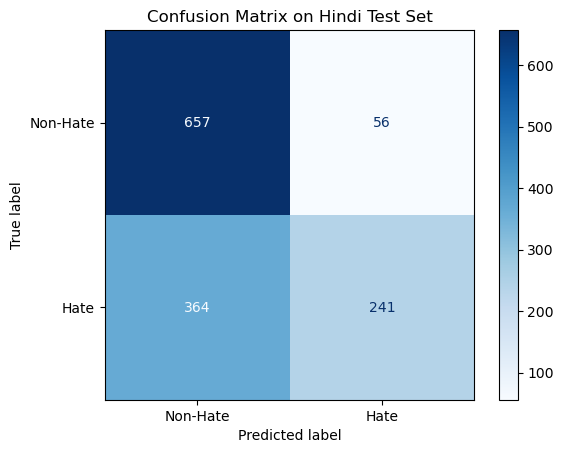

In [13]:
# Get predictions for confusion matrix
predictions_output = trainer.predict(hasoc_test_dataset)
pred_labels = np.argmax(predictions_output.predictions, axis=-1)

# Compute confusion matrix
cm = confusion_matrix(hasoc_test_dataset["label"], pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Hate", "Hate"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Hindi Test Set")
plt.show()

In [4]:
# Load the HASOC 2019 Hindi test data for evaluation
hindi_test = pd.read_csv('data/hindi_dataset/hindi_dataset.tsv', sep='\t')

# Preprocess the Hindi test data
hindi_test = hindi_test[['text', 'task_1']]
label_mapping = {'HOF': 1, 'NOT': 0}
hindi_test['label'] = hindi_test['task_1'].map(label_mapping)
hindi_test = hindi_test.drop(columns=['task_1'])

# Convert the test data into a Hugging Face dataset
hindi_test_dataset = Dataset.from_pandas(hindi_test)

# Tokenize the Hindi test data
hindi_test_dataset = hindi_test_dataset.map(lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=128), batched=True)
hindi_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/4665 [00:00<?, ? examples/s]

In [5]:
# Load the evaluation metric using the evaluate library
metric = evaluate.load("f1")

# Define a function to compute metrics during evaluation
def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    f1 = metric.compute(predictions=predictions, references=labels, average='macro')
    accuracy = np.mean(predictions == labels)
    return {"macro_f1": f1['f1'], "accuracy": accuracy}

# # Define training arguments for evaluation
# training_args = TrainingArguments(
#     output_dir="results",
#     per_device_eval_batch_size=16,
#     logging_dir="./logs",
#     logging_steps=10,
# )

# # Initialize the Trainer for evaluation
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     eval_dataset=hasoc_test_dataset,
#     compute_metrics=compute_metrics,
# )
model = XLMRobertaForSequenceClassification.from_pretrained("fine_tuned_model/final_model")
trainer = Trainer(
    model=model,
    eval_dataset=hindi_test_dataset,
    compute_metrics=compute_metrics,
)


In [6]:
# Evaluate the model on the Hindi test data
results = trainer.evaluate()

# Print the evaluation results
print(f"Zero-Shot Evaluation Results On Hindi Data Using XLM-R: {results}")

Zero-Shot Evaluation Results On Hindi Data Using XLM-R: {'eval_loss': 2.208066701889038, 'eval_model_preparation_time': 0.0015, 'eval_macro_f1': 0.5593029300330891, 'eval_accuracy': 0.594855305466238, 'eval_runtime': 44.7559, 'eval_samples_per_second': 104.232, 'eval_steps_per_second': 13.049}


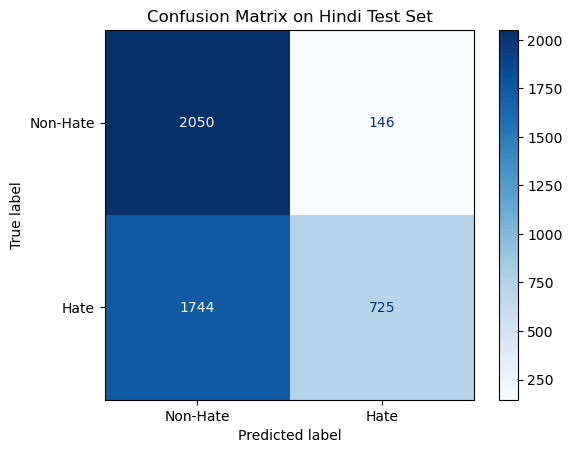

In [7]:
# Get predictions for confusion matrix
predictions_output = trainer.predict(hindi_test_dataset)
pred_labels = np.argmax(predictions_output.predictions, axis=-1)

# Compute confusion matrix
cm = confusion_matrix(hindi_test_dataset["label"], pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Hate", "Hate"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Hindi Test Set")
plt.show()